## Simple Four-Feature-Spaces Tutorial

In this tutorial, we will work through an simple, artificial ML problem to illustrate the full `Pyreal` workflow, including four unique feature spaces and multiple explanation types.

![title](feature_types.png)

### ML Problem Setup

In this example, we will use a simple ML model to predict the prices of hypothetical Trinkets based on five pieces of information:
1. Trinket Type `type` (categorical)
2. Trinket Color `color` (categorical)
3. Trinket Age `age` (integer)
4. Trinket Weight `width` (float)
4. Trinket Height `height` (float)

This information can be formatted in multiple ways - each of these introduces a new *feature space*.

### Original Feature Space

In this example, we have been given the data in what we will refer to as the **original** feature space, or `X_orig`. This is an arbitrary feature space, that includes the information in whatever form our data-collection team happened to use. Let's load in and take a look at this space now.

We see that we have five columns, one per piece of information listed above. The color feature is listed using HTML color codes, which are not very understandable to most people. The type feature is categorical, and can take one of three values - `foo`, `bar`, or `foobar`. The other three features are numeric, as expected.

In [1]:
import pandas as pd

data_orig =  pd.read_csv("trinket_data.csv", index_col=0)
y_orig = data_orig["price"]
X_orig = data_orig.drop("price", axis=1)

X_orig.head()

,color,age,width,height,type_bar,type_foo,type_foobar
0,#e51e32,41,43.569090,68.784567,1.0,0.0,0.0
1,#f51a2f,71,84.261218,60.542412,0.0,0.0,1.0
2,#21e308,90,71.574072,45.595469,1.0,0.0,0.0
3,#0630cf,32,23.125698,83.431874,0.0,1.0,0.0
4,#04d82b,44,54.253466,20.646017,0.0,0.0,1.0


### Model-Ready Feature Space

Let's go ahead and train a model to predict the price variable from the features. To do so, we will first need to transform the data to a model-ready standpoint. Our research on the topic of trinket-price-prediction has suggested that a simple linear regression model may work well. We also have the following domain knowledge that may be useful for feature engineering:
1. All trinkets are generally "reddish" or "blueish" - this is much more important to their price than the exact HTML color value.
2. Bigger trinkets sell for more - but the difference between width and height is arbitrary. In fact, only the larger of these axis matter

Based on this information, combined with the requirements of a linear regression model, let's put together some transformers using Pyreal's `transformer` package, and take a look at what the model-ready feature space looks like. As you can see, this feature space includes one-hot-encoded and aggregated features.

In [2]:
from pyreal.transformers import Transformer, OneHotEncoder, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from pyreal.transformers import fit_transformers, run_transformers


def hex_to_color_name(h):
    h = h.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return ["red", "green", "blue"][rgb.index(max(rgb))]

class ColorTransformer(Transformer):
    """
    Transforms a hex color to `red` or `blue`
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, x):
        return self

    def transform(self, x):
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x

    def transform_explanation(self, explanation):
        return explanation


class MaxAggregator(Transformer):
    """
    Converts a set of numeric features to a single feature of the max value
    """
    def __init__(self, columns):
        self.columns = columns

    def transform(self, x):
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x


colorTransformer = ColorTransformer(columns = ["color"])
colorEncoder = OneHotEncoder(columns = ["color"])
maxAggregator = MaxAggregator(columns=["width", "height"])
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar',
                                          'color_blue', 'color_green', 'color_red',
                                          'MAX(width,height)'])

model_transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect]
fit_transformers(model_transformers, X_orig)
X_model = run_transformers(model_transformers, X_orig)
X_model.head()

,age,type_bar,type_foo,type_foobar,color_blue,color_green,color_red,"MAX(width,height)"
0,41,1.0,0.0,0.0,0.0,0.0,1.0,68.784567
1,71,0.0,0.0,1.0,0.0,0.0,1.0,84.261218
2,90,1.0,0.0,0.0,0.0,1.0,0.0,71.574072
3,32,0.0,1.0,0.0,1.0,0.0,0.0,83.431874
4,44,0.0,0.0,1.0,0.0,1.0,0.0,54.253466


And now let's train a model and check the score...

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_model[0:400], y_orig[0:400])
print("Model r-squared: %.4f" % model.score(X_model[401:], y_orig[401:]))

Model r-squared: 0.9998


Our model development team has confirmed that this model performs well - but we would like to know how its making its predictions! How are our features interacting to give a price? Let's address this question by generating a local explanation for the first item in our dataset, using the popular explanation algorithm SHAP:

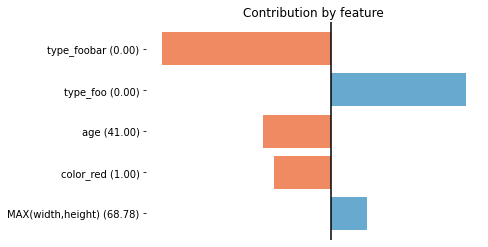

In [4]:
import shap
from pyreal.utils import visualize

explainer = shap.LinearExplainer(model, shap.maskers.Independent(data = X_model))
shap_values = explainer.shap_values(X_model[0:1])[0]
explanation = pd.DataFrame([shap_values], columns=X_model.columns)

visualize.plot_top_contributors(explanation, select_by="absolute", values=X_model.iloc[0])


The explanation above can be hard to parse. The fact that the trinket is not of type `foobar` is greatly decreasing the predicted price; the fact that it is not of type `foo` is greatly increasing it. This level of granularity, including things like one-hot-encoded features, may be useful for some users - especially ML experts looking to work on the model itself. But what about other users, for example Trinket sellers looking to use this model to help them decide on an appropriate Trinket price? Let's talk to some of them, and learn how they want their data presented.

### Interpretable feature space

There are some transforms we can apply to help. Our users want to see the features that actually contribute to the model prediction, but are confused when features are presented one-hot-encoded. Let's compile a few more transformers (from the original feature space again) - including some that were also useful for getting to the model-ready feature space. We'll take a look at the interpretable feature space.

We could make this space even more clear to human users with more descriptive feature names - but we'll add that in later.

In [5]:
mappings = Mappings.generate_mappings(
    categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings)
colorTransformer = ColorTransformer(columns = ["color"])

interpretable_transformers = [typeDecoder, colorTransformer, maxAggregator]

fit_transformers(interpretable_transformers, X_orig)
X_interpret = run_transformers(interpretable_transformers, X_orig)
X_interpret.head()

,color,age,type,"MAX(width,height)"
0,red,41,bar,68.784567
1,red,71,foobar,84.261218
2,green,90,bar,71.574072
3,blue,32,foo,83.431874
4,green,44,foobar,54.253466


### Pyreal Explainers

Many existing explanation algorithm implementations can't just take data in the interpretable form to produce an interpretable explanation - they have their own requirements for feature space.

Pyreal handles the details of transforming both data and explanations between feature spaces, using its `Explainer` classes and  `m_transformers`, `e_transformers`, and `i_transformers` parameters. Let's see how that works, and one again generate a local SHAP contribution explanation.

The first thing we need to do is identify what feature space is required by the explanation type we'd like to use. We can take a look at the documentation for ShapFeatureContribution explainers to see that, in this case, the explanation algorithm expects data in the model-ready feature space. We set `e_transformers` to the set of transformers that takes us to this space from the original feature space. We then set `m_transformers` to the list of transformers that takes use from this explanation-ready space to the model-ready space (in this case, there are none - these spaces are identical). We set the `i_transformers` to the list of transformers that takes us from the original feature space to the most interpretable option.

In [6]:
from pyreal.explainers import ShapFeatureContribution

explainer = ShapFeatureContribution(model, X_orig,
                                    e_transformers=model_transformers,
                                    i_transformers=interpretable_transformers,
                                    fit_on_init=True,
                                    stop_on_missing_transform=False)

We can now produce and visualize an explanation

Transformer class MaxAggregator does not have the required explanation transform
Transformer class ColorTransformer does not have the required inverse explanation transform
Transformer class MaxAggregator does not have the required inverse explanation transform
         age MAX(width,height)      color      type
0 -15.656246          8.279705 -20.622256 -8.060027


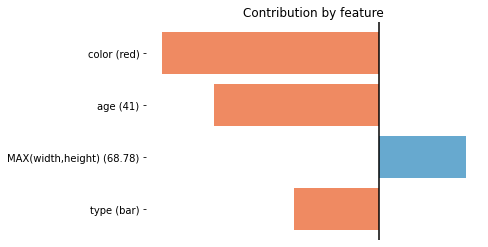

In [7]:
explanation = explainer.produce(X_orig.iloc[0])
print(explanation)

X_interpret = explainer.convert_data_to_interpretable(X_orig.iloc[0:1])
visualize.plot_top_contributors(explanation, select_by="absolute", values=X_interpret.iloc[0])

You may notice the warning `Transformer class MaxAggregator does not have the required explanation transform`. This is because we did not provide a way of distributing contribution for this kind of aggregation. The final explanation therefore includes a contribution for the aggregated MAX feature - which works well, as that's also what we determined to be more interpretable.

Next, we can generate an interpretable explanation using a different algorithm - the `SimpleCounterfactualContribution` explainer. This explainer requires features in a different feature space, using categorical features.

Transformer class MappingsOneHotDecoder does not have the required explanation transform
Stopping explanation transform process


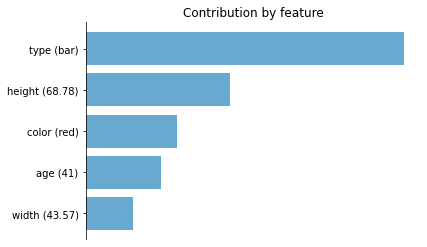

In [8]:
from pyreal.explainers import SimpleCounterfactualContribution

typeEncoder = OneHotEncoder(columns = ["type"])
fit_transformers([typeDecoder, typeEncoder], X_orig)

explainer = SimpleCounterfactualContribution(model, X_orig,
                                             e_transformers=[typeDecoder],
                                             m_transformers=[typeEncoder, maxAggregator, colorTransformer, colorEncoder, featureSelect],
                                             i_transformers=[typeDecoder, colorTransformer],
                                             fit_on_init=True)

explanation = explainer.produce(X_orig.iloc[0:1])
X_interpret = explainer.convert_data_to_interpretable(X_orig.iloc[0:1])
visualize.plot_top_contributors(explanation, select_by="absolute", values=X_interpret.iloc[0])

Transformer class MaxAggregator does not have the required explanation transform
Stopping explanation transform process
       color        age       type  MAX(width,height)
0  19.814137  19.273332  50.031031          34.501713


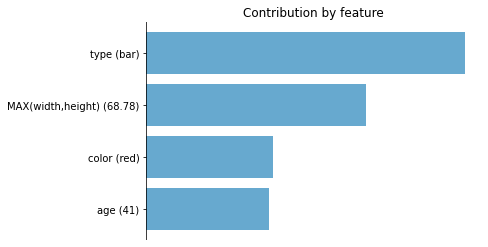

In [9]:
explainer = SimpleCounterfactualContribution(model, X_orig,
                                             e_transformers=[typeDecoder, maxAggregator],
                                             m_transformers=[typeEncoder, colorTransformer, colorEncoder, featureSelect],
                                             i_transformers=[maxAggregator, typeDecoder, colorTransformer],
                                             fit_on_init=True)

explanation = explainer.produce(X_orig.iloc[0:1])
print(explanation)
X_interpret = explainer.convert_data_to_interpretable(X_orig.iloc[0:1])
visualize.plot_top_contributors(explanation, select_by="absolute", values=X_interpret.iloc[0])

Transformer class MaxAggregator does not have the required explanation transform
Transformer class ColorTransformer does not have the required inverse explanation transform
Transformer class MaxAggregator does not have the required inverse explanation transform


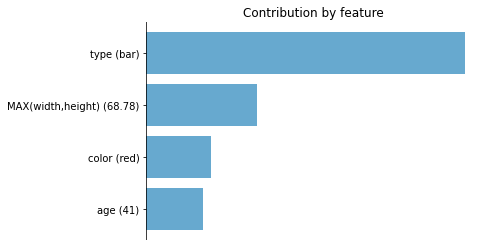

In [10]:
from pyreal.explainers import ShapFeatureImportance

explainer = ShapFeatureImportance(model, X_orig,
                                  e_transformers=model_transformers,
                                  i_transformers=interpretable_transformers,
                                  fit_on_init=True,
                                  stop_on_missing_transform=False)

explanation = explainer.produce()
X_interpret = explainer.convert_data_to_interpretable(X_orig.iloc[0:1])
visualize.plot_top_contributors(explanation, select_by="absolute", values=X_interpret.iloc[0])